In [1]:
import requests
import json
from tqdm import tqdm
from datetime import datetime
import itertools
import string
from collections import Counter, defaultdict
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# fetch and structure the dataset

In [3]:
NUM_STORIES = 1000000 # Number of top stories to be retrieved
NUM_KIDS = 1000000 # aka "kids" as referred to by hackernews documentation

In [1]:
# Define the base URL for the Hacker News API
BASE_URL = 'https://hacker-news.firebaseio.com/v0'

# retrieves relevant keywords
keywords = []
with open('ai_keywords.txt', 'r', encoding='utf-8') as keywordstxt:
    keywords = [line.rstrip('\n') for line in keywordstxt]
print(keywords)

['Artificial Intelligence', 'AI', 'Machine Learning', 'ML', 'Deep Learning', 'Neural Networks', 'NLP', 'Natural Language Processing', 'Large Language Models', 'LLM', 'Transformer', 'BERT', 'GPT-3', 'GPT-4', 'OpenAI Codex', 'T5', 'Text-to-Text Transfer Transformer', 'RoBERTa', 'XLNet', 'Chatbot', 'OpenAI', 'ChatGPT', 'Codex', 'DALL-E', 'GPT', 'API', 'OpenAI API', 'Fine-tuning', 'Prompt Engineering', 'AI Assistant', 'Ethics', 'AI Ethics', 'Data Privacy', 'Bias', 'Generative AI', 'AI-driven Development', 'Automated Coding', 'AI-enhanced Tools']


In [5]:
def get_top_story_ids():
    response = requests.get(f'{BASE_URL}/topstories.json')
    return response.json()[:NUM_STORIES]

# Stories/comments/jobs/pools are just items. This returns data of that item e.g. text, kids, title, time, etc.
# To obtain item data based on id
def get_item(item_id):
    response = requests.get(f'{BASE_URL}/item/{item_id}.json')
    return response.json()

# For easier data analysis - rather than storing ids of kids, we store their texts as well
def get_kids_text(item, depth=1):
    if 'kids' not in item or depth <= 0:
        return []

    kids_texts = []
    for kid_id in item['kids'][:NUM_KIDS]:
        kid = get_item(kid_id)
        if kid and 'text' in kid:
            kids_texts.append(kid['text'])
            kids_texts.extend(get_kids_text(kid, depth - 1))
    return kids_texts

def search_stories(keywords):
    top_story_ids = get_top_story_ids()
    relevant_stories = []

    # Store only stories relevant to the keywords to filter out unrelated discussions
    for story_id in tqdm(top_story_ids, desc="Fetching top stories"):
        story = get_item(story_id)
        if story and 'title' in story:
            title = story['title'].lower()
            if any(keyword.lower() in title for keyword in keywords):
                story['kids_texts'] = get_kids_text(story)
                relevant_stories.append(story)

    return relevant_stories

def save_to_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

In [6]:
relevant_stories = search_stories(keywords)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'hackernews_discussions_{timestamp}.json'
save_to_json(relevant_stories, filename)
print(f'Saved {len(relevant_stories)} stories to {filename}')

Fetching top stories: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]

Saved 12 stories to hackernews_discussions_20240617_152401.json


# process and analyze

## setup

In [7]:
# Load the saved dataset
with open(filename) as f:
    data = json.load(f)

# Initialize NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))
# Add common punctuation to stopwords
stop_words.update(string.punctuation)

# Initialize the word frequency dictionary and co-occurrence matrix
word_freq = Counter()
co_occurrence = defaultdict(Counter)

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Function to count words and update co-occurrence matrix in a text
def process_text(text):
    if text:
        tokens = word_tokenize(text.lower())
        filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        word_freq.update(filtered_tokens)
        for pair in itertools.combinations(filtered_tokens, 2):
            co_occurrence[pair[0]][pair[1]] += 1
            co_occurrence[pair[1]][pair[0]] += 1

In [9]:
# Process each story and its comments
for story in data:
    title = story.get('title', '')
    story_texts = ' '.join(story.get('kids_texts', []))
    process_text(title)
    process_text(story_texts)

print("Word frequency and co-occurrence matrix calculated.")

Word frequency and co-occurrence matrix calculated.


In [10]:
# Step 1: Extract the most common words
most_common_words = [word for word, _ in word_freq.most_common(20)]

# Display the most common words
print("Most common words:")
for word, count in word_freq.most_common(20):
    print(f"{word}: {count}")

Most common words:
p: 74
https: 38
quot: 37
wikipedia: 28
ai: 23
wiki: 23
nofollow: 18
get: 16
gt: 16
one: 12
someone: 10
article: 10
also: 10
models: 10
could: 9
business: 9
company: 9
would: 9
work: 9
even: 8


In [11]:
# Step 2: Create a co-occurrence matrix for the most common words
matrix = np.zeros((len(most_common_words), len(most_common_words)))
word_index = {word: i for i, word in enumerate(most_common_words)}

for word1, word2_counts in co_occurrence.items():
    if word1 in word_index:
        for word2, count in word2_counts.items():
            if word2 in word_index:
                i, j = word_index[word1], word_index[word2]
                matrix[i, j] = count

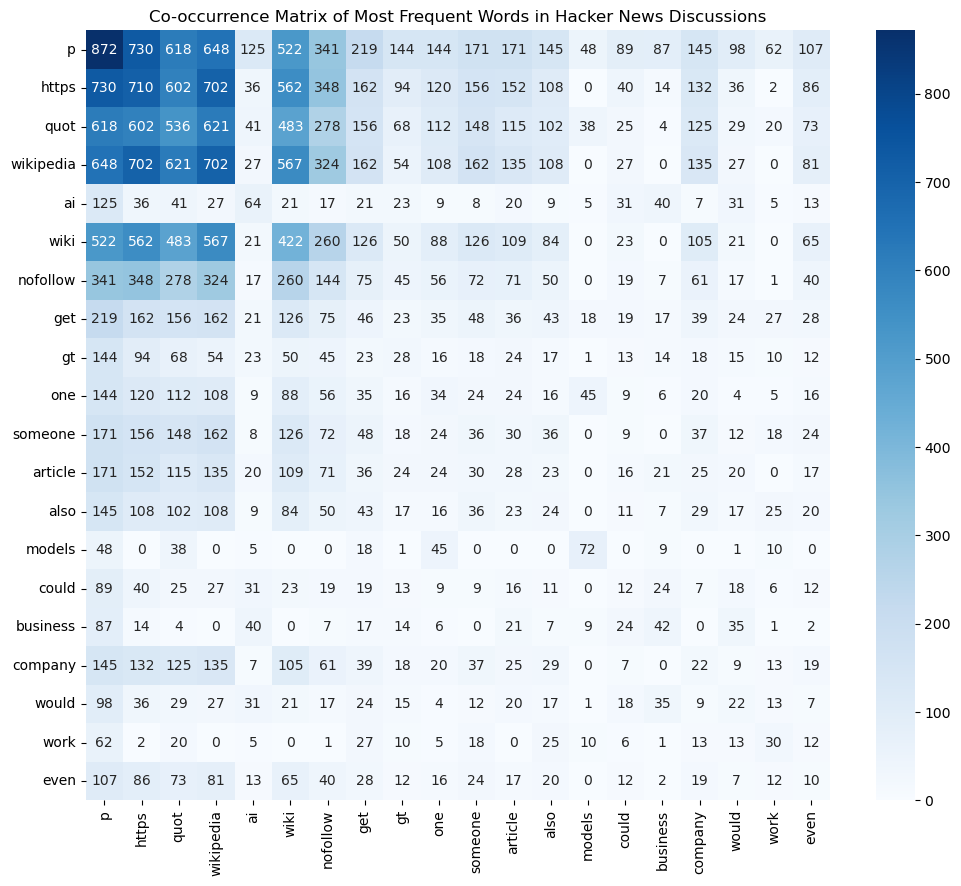

In [14]:
# Step 3: Visualize the co-occurrence matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    matrix,
    xticklabels=most_common_words,
    yticklabels=most_common_words,
    cmap='Blues',
    annot=True,
    fmt='.0f'
)
plt.title('Co-occurrence Matrix of Most Frequent Words in Hacker News Discussions')
plt.show()